# Easy Machine Learning with PyCaret
> "This notebook shows a basic data science workflow using Pycaret - a new Python machine learning library"
- toc: false
- author: "Dwight Gunning"
- image: /images/Pycaret.png
- branch: master
- badges: true
- comments: true
- categories: [notebooks,machine learning,pycaret]

# What is Pycaret

Pycaret is a new machine learning library that simplifies machine learning workflows. It is a high level library that sits on top of the most popular ML libraries - including general purpose libraries such as **scikit-learn**, tree-based such as **lightgbm**, **xgboost** and **catboost**, and NLP libraries such as **nltk**, **gensim** and **spacy**. In a sense pycaret shifts the focus from the implementation of mathematical algorithms to the implementation of ML workflow algorithms. Some of pycaret's functions, such as **setup**, **create_model**, **predict_model**, **plot_model**, are meant to perform a part of a typical data science project, while abstracting away from how the actual libraries underneath operate.

In this sense it is a little bit like build tools **Maven** and **Gradle**, tools that did not really care how the underlying tools in your project operated but focused instead on the workflow of producing build artifacts at the end. It is more of an ML workflow library with a set of opinionated workflow algorithms that guide how a data science project is created. 

If you recall **Maven** artifacts are written in the scripting language most familiar to developers at the time - XML. Jupyter notebooks have the same familiarity for data scientists now - most data scientists use them. Pycaret is unapologetically intended for use in Jupyter notebooks - several of the functions output data to be displayed in a notebook as the data science project is being created. So for example, - when you load using `get_data` - it displays the data that was loaded in the notebook. This makes use of the **IPython.display**. Pycaret also uses **ipywidgets** to show tabs or other UI elements useful to assist a data scientist while working on a data science project. This is familiar to me - I have written a few Jupyter first libraries of my [own](http://dgunning.com/blog/notebooks/covid19/2020/05/08/building-a-covid19-research-engine.html)  

# Getting Started

To get started install pycaret. In the best case scenario it's a simple as 
```bash
pip install pycaret
```

For more details go to the [Pycaret Install page](https://pycaret.org/install/)

## Included Datasets

Pycaret includes several datasets to get started with. To use the included data, import the **datasets** package from pycaret. 

In [1]:
from pycaret.datasets import get_data

Included with pycaret is a small dataset called **juice**. This small dataset has information about 1070 purchases of **Citrus Hill** or **Minute Maid** orange juice. It is originally meant for **R** projects and so is hosted on **rdrr.io**, a site where searching for R related packages and data. Because the data is small, it is conveniently included in the pycaret library. 

To get the data use the `get_data` function. This conveniently also displays the data in the notebook.

In [27]:
juice_dataset = get_data('juice')

,Id,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


The data seems complete and mostly numeric. The only weird thing about the data is that `Id` column, which we do not need because pandas generates an index for us. So let's drop it. 

In [32]:
if 'Id' in juice_dataset:
    juice_dataset = juice_dataset.set_index('Id')

### Get Data Niceties
The get_data function has a couple of nice options. With `save` you can save a copy of the data in the local filesystem. With `profile` you can output a pandas profile report. You can see more details about `get_data` by running `get_data??` in a code cell

#### Pandas Profiling Report
When you include the `profile` parameter get_data will output a pandas_profiling report created using the **pandas_profile** library. This gives a lot of information about the dataset and its features. Normally this helps in the data exploration phase of a data science project, but it's nice to also have it included in a function to get data.

![Pandas Profiling Report](../images/pandas_profiling.png)
![Pandas Profiling Report](../images/pandas_profiling_correlation.png)

### More about the orange juice dataset
We can find out more about the juice dataset by visiting the webpage at [rdrr.io](https://rdrr.io/cran/ISLR/man/OJ.html). Aternatively, we can grab the html from the site and convert the data description into a pandas dataframe. For this we will use a **requests** and **BeautifulSoup**. Here is that code.

In [63]:
#collapse
import pandas as pd
from bs4 import BeautifulSoup
import requests

pd.options.display.max_colwidth = 120

# 1. Grab the HTML from the website
r = requests.get('https://rdrr.io/cran/ISLR/man/OJ.html')

# 2. And convert it to a BeautifulSoup object
soup = BeautifulSoup(r.text)

def find_cells(soup, element):
    for dl in soup.find_all('dl'):
        for dt in dl.find_all('dt'):
            
            # 3. Once we find the <dt> element return it along with the <dd> element
            yield dt.text.strip(), dt.nextSibling.text.strip().replace('\n', ' ')
            
# 4. Convert the generator to a list of tuples
dt = list(find_cells(soup, 'dt'))

# 5. Now create a dataframe from the list of tuples
pd.DataFrame(dt, columns=['Feature','Description']).style.hide_index()

Feature,Description
Purchase,A factor with levels CH and MM indicating whether the customer purchased Citrus Hill or Minute Maid Orange Juice
WeekofPurchase,Week of purchase
StoreID,Store ID
PriceCH,Price charged for CH
PriceMM,Price charged for MM
DiscCH,Discount offered for CH
DiscMM,Discount offered for MM
SpecialCH,Indicator of special on CH
SpecialMM,Indicator of special on MM
LoyalCH,Customer brand loyalty for CH


## Preparing Data
First, we split the data into training and test set. It is a small dataset and maybe we can get by with an **80/20** split, especially since we will use tree based algorithms or similar algorithms that can handle small datasets.

In [53]:
train = juice_dataset.sample(frac=0.80)
unseen_data = juice_dataset.drop(train.index).reset_index(drop=True)

train.shape, test.shape

((856, 18), (214, 18))

## The setup function
At the heart of Pycaret has a powerful machine learning pipeline that takes the input data and performs a huge part of the traditional data processing workflow. This pipeline is started by calling the `setup` function. `setup` initializes the environment, and creates the data transformation pipeline to prepare the data for model training. 

It is a bit of a magic function - a lot of work is done inside this function and it has to be called before any of the pycaret model development is started. You call setup on your training data and tell it the target variable, and it will start preparing for model training. Importantly, it does some of the work that data scientists would be doing manually at this point, including making decisions about some of the preprocessing steps, such as apply PCA, or removing outliers etc. How well it does this is yet to be seen but it is certainly a big change to a data scientist's workflow if this can be done automatically. A lt of steps are done automatically by pycaret, as we will see later.

Regardless, setup displays a dataframe with information it discovers about the data's features and includes some of the decisions that were taken. This give a nice platform for ML modeling.

In [54]:
from pycaret.classification import *

juice_prep = setup(train, target='Purchase')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2574
1,Target Type,Binary
2,Label Encoded,"CH: 0, MM: 1"
3,Original Data,"(856, 18)"
4,Missing Values,False
5,Numeric Features,12
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## Compare Models
Once the data is prepared, a data scientist would now choose among candidate models. Again, there is another magic function `compare_models` which does this for you. This runs several models - 15 as shown below - on the data , and display key metrics to allow ypu to choose among the model types for the next step.

In [55]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.826500,0.893900,0.771300,0.792000,0.779900,0.636900
1,Linear Discriminant Analysis,0.824800,0.904300,0.776000,0.785100,0.780100,0.634500
2,Logistic Regression,0.823100,0.901500,0.746800,0.801700,0.771100,0.627400
3,Ridge Classifier,0.819800,0.000000,0.767700,0.780500,0.773300,0.623700
4,Ada Boost Classifier,0.816500,0.884300,0.738300,0.795000,0.762900,0.613700
5,Gradient Boosting Classifier,0.816500,0.893800,0.758800,0.780100,0.767000,0.615800
6,Random Forest Classifier,0.803100,0.869800,0.705200,0.787600,0.741200,0.583200
7,CatBoost Classifier,0.803100,0.892100,0.742200,0.762700,0.747500,0.586800
8,Light Gradient Boosting Machine,0.796400,0.886400,0.721200,0.762500,0.737000,0.571600
9,Extra Trees Classifier,0.771300,0.846400,0.696700,0.726200,0.707900,0.520500


### Available Models

In [48]:
pd.read_csv('pycaret_models.csv').style.hide_index()

Estimator,Abbreviated String,Original Implementation
Logistic Regression,lr,linear_model.LogisticRegression
K Nearest Neighbour,knn,neighbors.KNeighborsClassifier
Naives Bayes,nb,naive_bayes.GaussianNB
Decision Tree,dt,tree.DecisionTreeClassifier
SVM (Linear),svm,linear_model.SGDClassifier
SVM (RBF),rbfsvm,svm.SVC
Gaussian Process,gpc,gaussian_process.GPC
Multi Level Perceptron,mlp,neural_network.MLPClassifier
Ridge Classifier,ridge,linear_model.RidgeClassifier
Random Forest,rf,ensemble.RandomForestClassifier


## Create Model
Assuming we decide to use the **Ridge Classifier**, then the next function is intuitively `create_model`. This will create a Ridge Classifier model with default hyper parameters.

In [56]:
rc = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8000,0.0,0.7500,0.7500,0.7500,0.5833
1,0.8000,0.0,0.7500,0.7500,0.7500,0.5833
2,0.8667,0.0,0.8333,0.8333,0.8333,0.7222
3,0.7833,0.0,0.6667,0.7619,0.7111,0.5390
4,0.8500,0.0,0.8333,0.8000,0.8163,0.6897
5,0.8167,0.0,0.7083,0.8095,0.7556,0.6099
6,0.8833,0.0,0.8750,0.8400,0.8571,0.7586
7,0.7500,0.0,0.6667,0.6957,0.6809,0.4755
8,0.7833,0.0,0.7600,0.7308,0.7451,0.5568
9,0.8644,0.0,0.8333,0.8333,0.8333,0.7190


## Tune Model

Instead of `create_model`, which uses default parameters and so might not have optimal performance, you can call `tune_model`. This will automatically tune the model's hyperparameters.

In [57]:
ridge_tuned = tune_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8000,0.0,0.7500,0.7500,0.7500,0.5833
1,0.8000,0.0,0.7500,0.7500,0.7500,0.5833
2,0.8833,0.0,0.8750,0.8400,0.8571,0.7586
3,0.7833,0.0,0.6667,0.7619,0.7111,0.5390
4,0.8500,0.0,0.8333,0.8000,0.8163,0.6897
5,0.8167,0.0,0.7083,0.8095,0.7556,0.6099
6,0.8833,0.0,0.8750,0.8400,0.8571,0.7586
7,0.7500,0.0,0.6667,0.6957,0.6809,0.4755
8,0.7833,0.0,0.7600,0.7308,0.7451,0.5568
9,0.8644,0.0,0.8333,0.8333,0.8333,0.7190


## Plot Model

Another nice feature that pycaret provides is the ability to plot different charts that can tell you how your model performs. For our ridge classifier we can plot a Precision-Recall Curve using `plot_model(plot='pr')`. There are many different types of plots and it would be cool to try them out.

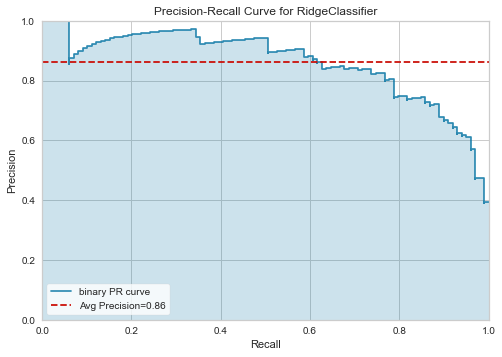

In [52]:
plot_model(ridge_tuned, plot = 'pr')

## Predict
Finally, when we call `predict_model` pycaret runs the predictions and appends the labels to the original data.

In [62]:
unseen_predictions = predict_model(ridge_tuned, data=unseen_data)
unseen_predictions[['Purchase', 'Label']]

,Purchase,Label
0,MM,1
1,CH,0
2,CH,0
3,MM,1
4,CH,0
...,...,...
209,CH,0
210,MM,1
211,CH,0
212,MM,1


# Conclusion
**pycaret** is fun to use and it is useful. 